<a href="https://colab.research.google.com/github/SanSint/ElderSafe-Simulation/blob/main/Hybrid_result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phase 2: Environmental Data Integration & Simulation

Original data shape: (2764, 24)
Hybrid dataset size: (2964, 25)

Risk level distribution in hybrid dataset:
risk_level
safe       1760
warning     623
danger      581
Name: count, dtype: int64


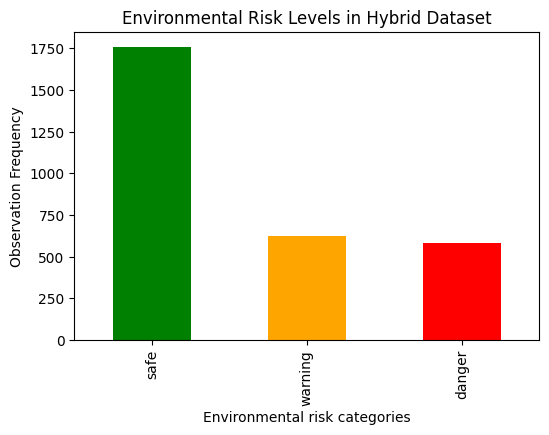


Variable Definition:

X-axis : Environmental risk categories ('Safe', 'Warning', 'Danger') assigned to each observation 
 in the hybrid dataset based on threshold conditions.
Y-axis : Observation frequency representing how many data records fall within each risk category.

 Hybrid dataset saved as 'Hybrid_SML2010_with_labels.csv'


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import files

#  Load the SML2010 dataset (space-delimited text file)
df = pd.read_csv('NEW-DATA-1.T15.txt', sep=' ')


print("Original data shape:", df.shape)
df.head()

# Generate synthetic extreme conditions & define how many extra samples to create

n_extreme = 200

# Randomly pick base rows, then modify values to create extremes
extreme = df.sample(n_extreme, random_state=42).copy()
extreme['3:Temperature_Comedor_Sensor'] += np.random.choice([+10, -10], size=n_extreme)     # heatwave / cold snap
extreme['8:Humedad_Comedor_Sensor'] += np.random.choice([+25, -25], size=n_extreme)        # high / low humidity
extreme['6:CO2_Comedor_Sensor'] += np.random.choice([+600, +1000], size=n_extreme)          # poor ventilation

extreme['source'] = 'synthetic'
df['source'] = 'real'

# Combining real + synthetic data
hybrid_df = pd.concat([df, extreme], ignore_index=True)
print("Hybrid dataset size:", hybrid_df.shape)

# 4 Applying public-health thresholds for safe/warning/danger
def classify_condition(temp, hum, co2):
    # --- Simple WHO/EPA-style thresholds ---
    if (temp < 16 or temp > 30) or (hum < 30 or hum > 70) or (co2 > 1000):
        return 'danger'
    elif (temp < 18 or temp > 28) or (hum < 35 or hum > 65) or (co2 > 800):
        return 'warning'
    else:
        return 'safe'

hybrid_df['risk_level'] = hybrid_df.apply(
    lambda x: classify_condition(x['3:Temperature_Comedor_Sensor'], x['8:Humedad_Comedor_Sensor'], x['6:CO2_Comedor_Sensor']),
    axis=1
)

#Inspect distribution
print("\nRisk level distribution in hybrid dataset:")
print(hybrid_df['risk_level'].value_counts())

#Quick visualization
plt.figure(figsize=(6,4))
hybrid_df['risk_level'].value_counts().plot(kind='bar', color=['green','orange','red'])
plt.title('Environmental Risk Levels in Hybrid Dataset')
plt.xlabel('Environmental risk categories')
plt.ylabel('Observation Frequency')
plt.show()

#explaination
print("\nVariable Definition:\n")
print("X-axis : Environmental risk categories ('Safe', 'Warning', 'Danger') assigned to each observation \n in the hybrid dataset based on threshold conditions.")
print("Y-axis : Observation frequency representing how many data records fall within each risk category.")


#Save processed dataset for factor alert table
hybrid_df.to_csv('Hybrid_SML2010_with_labels.csv', index=False)



print("\n Hybrid dataset saved as 'Hybrid_SML2010_with_labels.csv'")

##Comparison between real and Synthetic data distrubtions (Mean standard deviation)

In [8]:
import pandas as pd
import numpy as np

hybrid_df["source"] = "Real data"
hybrid_df.loc[hybrid_df.index[-200:], "source"] = "synthetic"

metrics = []
for src in ["Real data", "synthetic"]:
    sub = hybrid_df[hybrid_df["source"] == src]
    t_mean, t_sd = sub["3:Temperature_Comedor_Sensor"].mean(), sub["3:Temperature_Comedor_Sensor"].std(ddof=1)
    h_mean, h_sd = sub["8:Humedad_Comedor_Sensor"].mean(), sub["8:Humedad_Comedor_Sensor"].std(ddof=1)
    c_mean, c_sd = sub["6:CO2_Comedor_Sensor"].mean(), sub["6:CO2_Comedor_Sensor"].std(ddof=1)
    metrics.append({
        "Subset": src.capitalize(),
        "Temperature (°C)": f"{t_mean:.1f} ± {t_sd:.1f}",
        "Humidity (%)": f"{h_mean:.1f} ± {h_sd:.1f}",
        "CO₂ (ppm)": f"{c_mean:.0f} ± {c_sd:.0f}"
    })

stats_table = pd.DataFrame(metrics)
# Display the styled table properly
from IPython.display import display

styled_table = stats_table.style.set_table_styles([
    {'selector': 'th', 'props': [('border', '1px solid black'), ('padding', '6px')]},
    {'selector': 'td', 'props': [('border', '1px solid black'), ('padding', '6px')]},
    {'selector': 'table', 'props': [('border-collapse', 'collapse'), ('width', '60%')]}
]).set_caption("Comparison of real and synthetic environmental data distributions (mean ± SD)")

# put border
display(styled_table)
##print(stats_table)


,Subset,Temperature (°C),Humidity (%),CO₂ (ppm)
0,Real data,19.2 ± 2.9,44.9 ± 6.6,208 ± 27
1,Synthetic,20.1 ± 10.1,43.9 ± 25.7,1030 ± 201


In [ ]:
# Print first 5 lines of the DataFrame in a table
display(df.head())

# List the columns of the DataFrame
print("\nDataFrame Columns:")
print(df.columns.tolist())

,1:Date,2:Time,3:Temperature_Comedor_Sensor,4:Temperature_Habitacion_Sensor,5:Weather_Temperature,6:CO2_Comedor_Sensor,7:CO2_Habitacion_Sensor,8:Humedad_Comedor_Sensor,9:Humedad_Habitacion_Sensor,10:Lighting_Comedor_Sensor,...,16:Meteo_Exterior_Sol_Est,17:Meteo_Exterior_Sol_Sud,18:Meteo_Exterior_Piranometro,19:Exterior_Entalpic_1,20:Exterior_Entalpic_2,21:Exterior_Entalpic_turbo,22:Temperature_Exterior_Sensor,23:Humedad_Exterior_Sensor,24:Day_Of_Week,source
0,13/03/2012,11:45,18.1875,17.8275,0.0,216.560,221.920,39.9125,42.4150,81.6650,...,12604.20,95436.8,758.880,0,0,0,18.1150,48.3750,2.0,real
1,13/03/2012,12:00,18.4633,18.1207,6.8,219.947,220.363,39.9267,42.2453,81.7413,...,10787.20,95436.8,762.069,0,0,0,18.4147,47.8080,2.0,real
2,13/03/2012,12:15,18.7673,18.4367,17.0,219.403,218.933,39.7720,42.2267,81.4240,...,9669.63,95398.6,766.251,0,0,0,18.8533,47.4320,2.0,real
3,13/03/2012,12:30,19.0727,18.7513,18.0,218.613,217.045,39.7760,42.0987,81.5013,...,9648.13,95360.3,766.037,0,0,0,19.2907,47.0240,2.0,real
4,13/03/2012,12:45,19.3721,19.0414,20.0,217.714,216.080,39.7757,42.0686,81.4657,...,9208.32,95354.9,762.743,0,0,0,19.7400,45.4743,2.0,real



DataFrame Columns:
['1:Date', '2:Time', '3:Temperature_Comedor_Sensor', '4:Temperature_Habitacion_Sensor', '5:Weather_Temperature', '6:CO2_Comedor_Sensor', '7:CO2_Habitacion_Sensor', '8:Humedad_Comedor_Sensor', '9:Humedad_Habitacion_Sensor', '10:Lighting_Comedor_Sensor', '11:Lighting_Habitacion_Sensor', '12:Precipitacion', '13:Meteo_Exterior_Crepusculo', '14:Meteo_Exterior_Viento', '15:Meteo_Exterior_Sol_Oest', '16:Meteo_Exterior_Sol_Est', '17:Meteo_Exterior_Sol_Sud', '18:Meteo_Exterior_Piranometro', '19:Exterior_Entalpic_1', '20:Exterior_Entalpic_2', '21:Exterior_Entalpic_turbo', '22:Temperature_Exterior_Sensor', '23:Humedad_Exterior_Sensor', '24:Day_Of_Week', 'source']


##Phase 3: Elder Safe Alert Logic

Data loaded: (2964, 26)
Aggregated columns added: temperature, humidity, co2

Predicted alert distribution:
predicted_alert
safe       1067
danger     1065
warning     832
Name: count, dtype: int64

Match vs Phase 2 labels: 55.13%


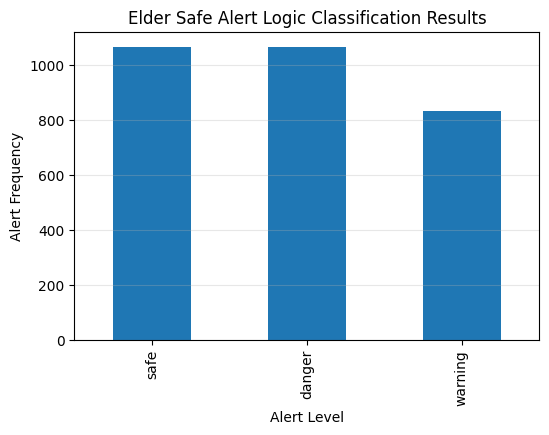


Variable Definition:

X-axis : Independent variables corresponding to environmental parameters — Temperature, Humidity, and CO₂ levels.
Y-axis : Dependent variable indicating the alert frequency outcomes ('Safe', 'Warning', 'Danger') generated by 
 the Elder Safe Alert Logic.

File saved as 'Hybrid_SML2010_with_alerts.csv'


In [ ]:

# Phase 3: Elder Safe Alert Logic (Rule-Based Framework)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the hybrid dataset

path = "Hybrid_SML2010_with_labels.csv"
if 'hybrid_df' in globals():
    df = hybrid_df.copy()
elif os.path.exists(path):
    df = pd.read_csv(path)
else:
    raise FileNotFoundError("Run Phase 2 first, or check the file path for Hybrid_SML2010_with_labels.csv.")

print("Data loaded:", df.shape)
#print("Columns:", list(df.columns)[:5])

# Identify temperature, humidity, and CO2 columns
# from the NEW-DATA-1.T15.txt file (SML2010 dataset)
temp_cols = [c for c in df.columns if 'temp' in c.lower()]
hum_cols  = [c for c in df.columns if 'hum' in c.lower()]
co2_cols  = [c for c in df.columns if 'co2' in c.lower()]

if not temp_cols or not hum_cols or not co2_cols:
    raise KeyError("Could not detect temperature/humidity/CO2 columns automatically. Check Phase 2 column names.")

# Combine average readings if multiple sensors exist
df['temperature'] = df[temp_cols].mean(axis=1)
df['humidity'] = df[hum_cols].mean(axis=1)
df['co2'] = df[co2_cols].mean(axis=1)

print("Aggregated columns added: temperature, humidity, co2")

# Define Elder Safe Alert Logic thresholds
TEMP_SAFE_MIN, TEMP_SAFE_MAX = 18, 28
TEMP_DANGER_MIN, TEMP_DANGER_MAX = 16, 30
HUM_SAFE_MIN,  HUM_SAFE_MAX  = 35, 65
HUM_DANGER_MIN, HUM_DANGER_MAX = 30, 70
CO2_WARNING, CO2_DANGER = 800, 1000

def elder_safe_alert(temp, hum, co2):
    if (temp < TEMP_DANGER_MIN or temp > TEMP_DANGER_MAX) or \
       (hum < HUM_DANGER_MIN or hum > HUM_DANGER_MAX) or \
       (co2 > CO2_DANGER):
        return 'danger'
    elif (temp < TEMP_SAFE_MIN or temp > TEMP_SAFE_MAX) or \
         (hum < HUM_SAFE_MIN or hum > HUM_SAFE_MAX) or \
         (co2 > CO2_WARNING):
        return 'warning'
    else:
        return 'safe'

# Apply alert logic to each record
df['predicted_alert'] = df.apply(lambda x: elder_safe_alert(x['temperature'], x['humidity'], x['co2']), axis=1)

#Show summary
print("\nPredicted alert distribution:")
print(df['predicted_alert'].value_counts())

# Optional: compare to Phase 2 labels if present
if 'risk_level' in df.columns:
    acc = np.mean(df['predicted_alert'] == df['risk_level'])
    print(f"\nMatch vs Phase 2 labels: {acc*100:.2f}%")

# Visualize results
plt.figure(figsize=(6,4))
df['predicted_alert'].value_counts().plot(kind='bar')
plt.title('Elder Safe Alert Logic Classification Results')
plt.xlabel('Alert Level')
plt.ylabel('Alert Frequency')
plt.grid(axis='y', alpha=0.3)
plt.show()

#explaination
print("\nVariable Definition:\n")
print("X-axis : Independent variables corresponding to environmental parameters — Temperature, Humidity, and CO₂ levels.")
print("Y-axis : Dependent variable indicating the alert frequency outcomes ('Safe', 'Warning', 'Danger') generated by \n the Elder Safe Alert Logic.")


# Save updated dataset
df.to_csv("Hybrid_SML2010_with_alerts.csv", index=False)
print("\nFile saved as 'Hybrid_SML2010_with_alerts.csv'")


##Factor-Level Alert Table

In [ ]:
import pandas as pd

# Loading Phase 2 output
df = pd.read_csv("Hybrid_SML2010_with_labels.csv")

# Using same columns Phase 2 used
T = '3:Temperature_Comedor_Sensor'
H = '8:Humedad_Comedor_Sensor'
C = '6:CO2_Comedor_Sensor'
for col in [T,H,C]:
    if col not in df.columns:
        raise KeyError(f"Missing expected column: {col}")

# Thresholds (From Phase 2)
temp_warn = (df[T] < 18) | (df[T] > 28)
temp_dang = (df[T] < 16) | (df[T] > 30)

hum_warn  = (df[H] < 35) | (df[H] > 65)
hum_dang  = (df[H] < 30) | (df[H] > 70)

co2_warn  = (df[C] > 800)
co2_dang  = (df[C] > 1000)

# Compute non-overlapping bands per factor (independent of other factors)
# Danger wins over Warning; Safe is "not warning and not danger"

temp_safe = ~(temp_warn | temp_dang)
temp_warn_only = temp_warn & ~temp_dang
temp_dang_only = temp_dang

hum_safe = ~(hum_warn | hum_dang)
hum_warn_only = hum_warn & ~hum_dang
hum_dang_only = hum_dang

co2_safe = ~(co2_warn | co2_dang)
co2_warn_only = co2_warn & ~co2_dang
co2_dang_only = co2_dang

# Building table (counts are per factor, independent of other factors)
factors = ['Temperature','Humidity','CO2']
table = pd.DataFrame({
    'Safe Range':    [temp_safe.sum(),   hum_safe.sum(),   co2_safe.sum()],
    'Warning Range': [temp_warn_only.sum(), hum_warn_only.sum(), co2_warn_only.sum()],
    'Danger Range':  [temp_dang_only.sum(), hum_dang_only.sum(), co2_dang_only.sum()],
}, index=factors)

# "% of Total Alerts" (share of warning+danger by factor)
alerts_total_by_factor = table['Warning Range'] + table['Danger Range']
alerts_total = alerts_total_by_factor.sum()

table['% of Total Alerts warning + danger'] = (
    (alerts_total_by_factor / max(alerts_total, 1) * 100)
    .round(0)
    .astype(int)
    .astype(str) + '%'
)
# Display the styled table properly
from IPython.display import display

styled_table = table.style.set_table_styles([
    {'selector': 'th', 'props': [('border', '1px solid black'), ('padding', '6px')]},
    {'selector': 'td', 'props': [('border', '1px solid black'), ('padding', '6px')]},
    {'selector': 'table', 'props': [('border-collapse', 'collapse'), ('width', '60%')]}
]).set_caption("Alert Distribution by Environmental Factor")

# put border
display(styled_table)

table.to_csv("factor_alert_table_independent.csv", index=True)

# Extra: split the percentages for Danger-only and Warning-only

warning_total_by_factor = table['Warning Range']
danger_total_by_factor  = table['Danger Range']

total_warning = int(warning_total_by_factor.sum())
total_danger  = int(danger_total_by_factor.sum())

table['% of Danger (by factor)']  = (
    (danger_total_by_factor / max(total_danger, 1) * 100).round(0).astype(int).astype(str) + '%'
)
table['% of Warning (by factor)'] = (
    (warning_total_by_factor / max(total_warning, 1) * 100).round(0).astype(int).astype(str) + '%'
)

print("\nShare of TOTAL DANGER cases by factor:")
for factor, pct in table['% of Danger (by factor)'].items():
    print(f"- {factor}: {pct}")

print("\nShare of TOTAL WARNING cases by factor:")
for factor, pct in table['% of Warning (by factor)'].items():
    print(f"- {factor}: {pct}")

from IPython.display import display
display(table[['% of Danger (by factor)', '% of Warning (by factor)']])

cols = ['Safe Range','Warning Range','Danger Range',
        '% of Total Alerts','% of Danger (by factor)','% of Warning (by factor)']




,Safe Range,Warning Range,Danger Range,% of Total Alerts warning + danger
Temperature,1935,531,498,66%
Humidity,2615,183,166,22%
CO2,2778,78,108,12%



Share of TOTAL DANGER cases by factor:
- Temperature: 65%
- Humidity: 22%
- CO2: 14%

Share of TOTAL WARNING cases by factor:
- Temperature: 67%
- Humidity: 23%
- CO2: 10%


,% of Danger (by factor),% of Warning (by factor)
Temperature,65%,67%
Humidity,22%,23%
CO2,14%,10%
